In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


In [ ]:
ticker = "RELIANCE.NS"

data = yf.download(
    ticker,
    start="2018-01-01",
    end="2024-01-01",
    progress=False
)

prices = data["Close"].dropna()
returns = np.log(prices / prices.shift(1)).dropna()

sigma = returns.std() * np.sqrt(252)
sigma


/tmp/ipython-input-1444386982.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


,0
Ticker,
RELIANCE.NS,0.29742


In [ ]:
S0 = prices.iloc[-1]
K = S0               # ATM call
T = 0.5              # 6 months
r = 0.06             # risk-free rate
N = 126              # ~6 months of trading days
dt = T / N

In [ ]:
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

In [ ]:
np.random.seed(42)

prices_sim = np.zeros(N+1)
prices_sim[0] = S0

for t in range(1, N+1):
    z = np.random.normal()
    prices_sim[t] = prices_sim[t-1] * np.exp(
        (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    )

/tmp/ipython-input-3501038318.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices_sim[0] = S0
/tmp/ipython-input-3501038318.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices_sim[t] = prices_sim[t-1] * np.exp(


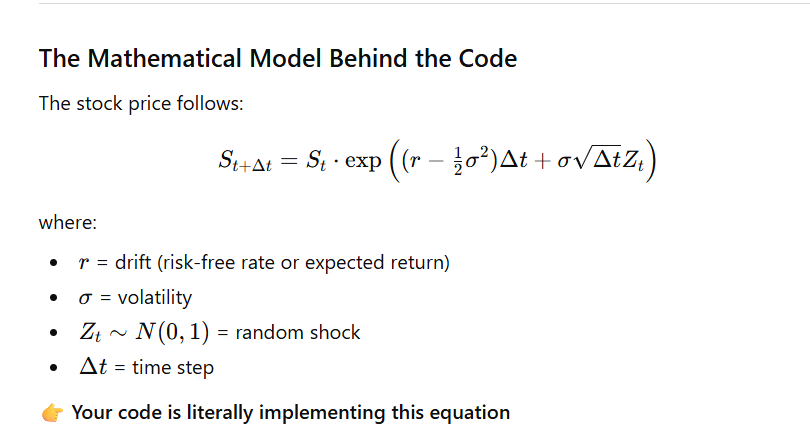

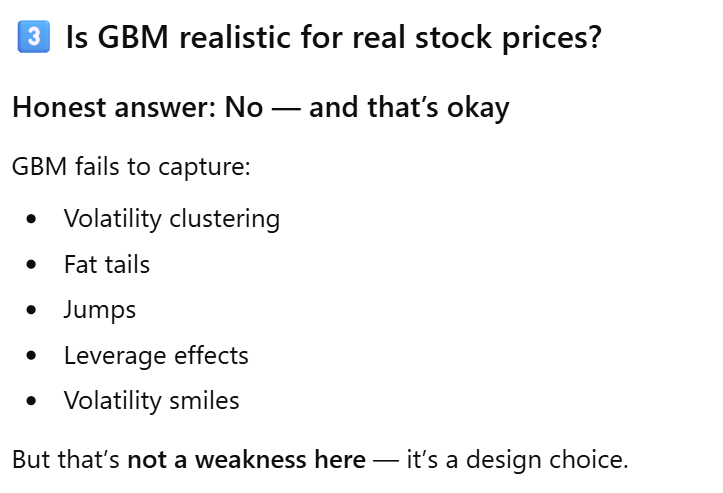

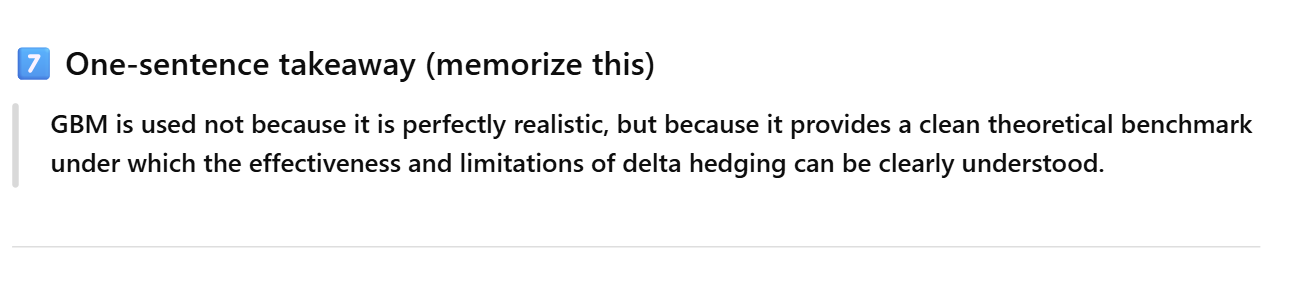

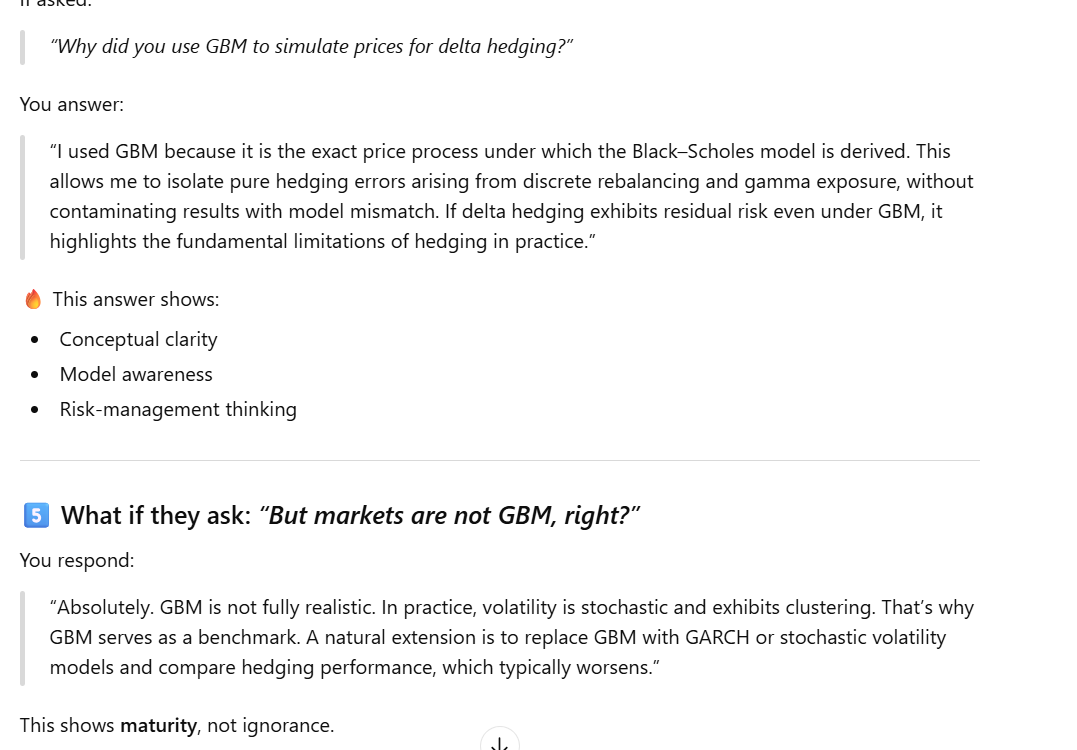

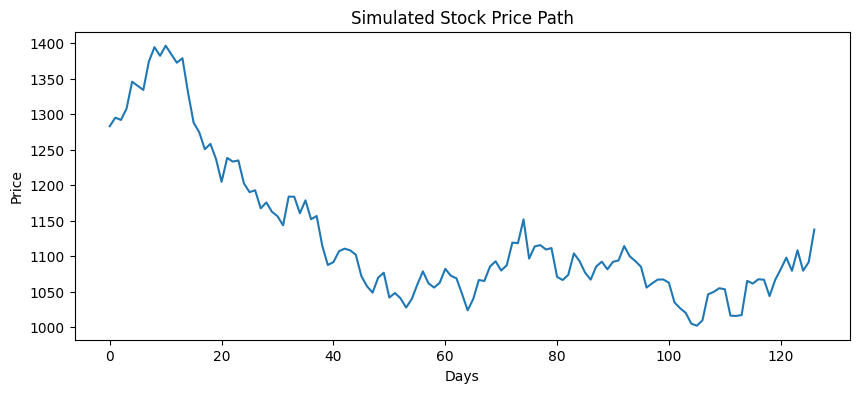

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(prices_sim)
plt.title("Simulated Stock Price Path")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [ ]:
call_price_0 = bs_call_price(S0, K, T, r, sigma)
delta_0 = bs_delta_call(S0, K, T, r, sigma)


In [ ]:
delta_0

array([0.5978562])

In [ ]:
shares = delta_0
cash = call_price_0 - delta_0 * S0

In [ ]:
cash *= np.exp(r * dt)

In [ ]:
cash

,2023-12-29
Ticker,
RELIANCE.NS,-641.302738


In [ ]:
portfolio_values = []

for t in range(1, N+1):
    tau = max(T - t*dt, 1e-6)
    S = prices_sim[t]

    # New delta
    delta_new = bs_delta_call(S, K, tau, r, sigma)

    # Change in shares needed
    delta_change = delta_new - shares

    # Buy/sell shares to rebalance
    cash -= delta_change * S
    shares = delta_new

    # Cash earns risk-free rate
    cash *= np.exp(r * dt)

    # Value of short call
    call_value = bs_call_price(S, K, tau, r, sigma)

    # Total hedged portfolio value
    portfolio_value = cash + shares * S - call_value
    portfolio_values.append(portfolio_value)


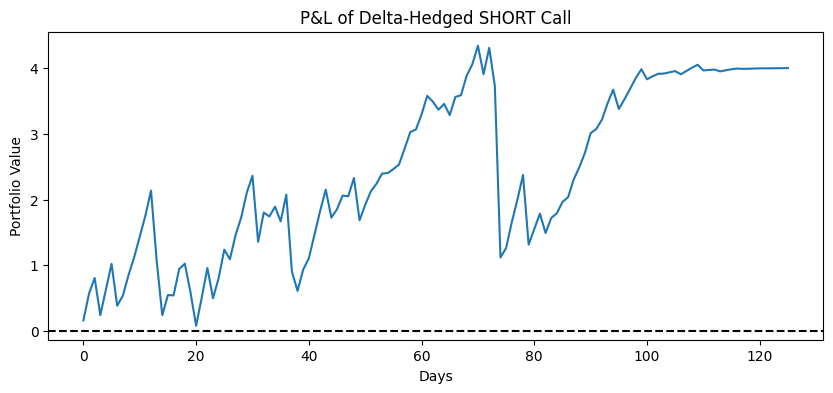

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(portfolio_values)
plt.axhline(0, color="black", linestyle="--")
plt.title("P&L of Delta-Hedged SHORT Call")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()


In [ ]:
hedging_error = portfolio_values[-1]
hedging_error


,2023-12-29
Ticker,
RELIANCE.NS,4.00385
